In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import nltk
from autocorrect import Speller
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

## Import the Data

In [2]:
df = pd.read_csv('Scrapper/final.csv', header=None)
# df.rename(columns={0: 'comment', 1: 'category'}, inplace=True)

## Exploring the Data

In [3]:
# Printing unique category
df[1].unique()

array(['positive', 'imperative', 'interrogative', 'other', 'correction',
       'negative'], dtype=object)

In [4]:
# removing duplicate rows
# df = df.drop_duplicates()
df.duplicated().any()

True

In [5]:
# Checking null values
df.isnull().sum()

0    0
1    0
dtype: int64

In [6]:
# Checking the shape of the data
df.shape

(1603, 2)

## Preprocessing

In [7]:
# Preprocessing

# lowercasing
df[0] = df[0].str.lower()

# removing urls
df[0] = df[0].str.replace('http\S+|www.\S+', '', case=False)

# removing new lines "\n"
df[0] = df[0].str.replace('\n',' ', regex=True)

# removing all the punctuations
df[0] = df[0].str.replace('[^\w\s]',' ')

# removing integers
df[0] = df[0].str.replace('\d','', regex=True)

# removing emojis
df[0] = df[0].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)
df

,0,1
0,love you sir,positive
1,please make videos on midpoint circle drawing...,imperative
2,i bought both of your courses on udemy you ar...,interrogative
3,thank you very much u really got me in the fi...,positive
4,i hope u are ok with everything going on again...,other
...,...,...
1598,sir can you please tell about enterprise java ...,interrogative
1599,bad in fluency,negative
1600,the latest version of the jdk adds thrree fold...,interrogative
1601,tell me criteria for windows,imperative


In [8]:
# df.rename(columns={'comment':0, 'category':1}, inplace=True)
# df

In [9]:
# # correcting the typos

# spell = Speller(lang='en')

# def typo_corrector(text):
#     return spell(text)

# df[0] = df[0].apply(typo_corrector)
# df[0]

In [10]:
# stemming
stemmer = nltk.stem.SnowballStemmer('english')
def stem_text(text):
    return stemmer.stem(text)

df[0] = df[0].apply(stem_text)


# lemmatizing
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

df[0] = df[0].apply(lemmatize_text)
df

,0,1
0,love you sir,positive
1,please make videos on midpoint circle drawing...,imperative
2,i bought both of your courses on udemy you ar...,interrogative
3,thank you very much u really got me in the fi...,positive
4,i hope u are ok with everything going on again...,other
...,...,...
1598,sir can you please tell about enterprise java ...,interrogative
1599,bad in flu,negative
1600,the latest version of the jdk adds thrree fold...,interrogative
1601,tell me criteria for windows,imperative


In [11]:
print(df[0][599])

not  good its not the video lecture that you want   


In [12]:
# Removing stopwords
stop = stopwords.words('english')

# These are the words that should not be removed from their category
negative_words = ['no','not']
interrogative_words = ['how','what','which','who','whom','why','do','does','is','are','was','were','will','am',
                      'are','could','would','should','can','did','does','do','had','have']
imperative_words = ['could','would','should','can']

for_negative_category = stop.copy()
for word in negative_words:
    if word in for_negative_category:
        for_negative_category.remove(word)
    
for_interrogative_category = stop.copy()
for word in interrogative_words:
    if word in for_interrogative_category:
        for_interrogative_category.remove(word)
    
for_imperative_category = stop.copy()
for word in imperative_words:
    if word in for_imperative_category:
        for_imperative_category.remove(word)

# For negative words
for i in range(len(df)):
    if df[1][i] == "negative":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in for_negative_category])

# For interrogative words
for i in range(len(df)):
    if df[1][i] == "interrogative":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in for_interrogative_category])
        
# For interrogative words
for i in range(len(df)):
    if df[1][i] == "imperative":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in for_imperative_category])
        
# For all other category
for i in range(len(df)):
    if df[1][i] == "positive" or df[1][i] == "correction" or df[1][i] == "other":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in stop])

# df[0] = df[0].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# df

## Feature Extaction

In [13]:
# df[0][195]

In [14]:
import math 

N_occurance = 5

words = [df[0][i].split() for i in range(len(df))]
bag_of_words = sorted(list({word for list_ in words for word in list_}))
word_count = {word:0 for word in bag_of_words}
for word in bag_of_words:
    for list_ in words:
        if word in list_:
            word_count[word]+=1
filtered_words = [k for k,v in word_count.items() if v>N_occurance]
evaluation = np.zeros((len(df),len(filtered_words)))
for i in range(len(words)):
    counter = Counter(words[i])
    for k, v in counter.items():
        if k not in filtered_words:
            continue
        count = [1 for list_ in words if k in list_]
        evaluation[i][filtered_words.index(k)] = sum(count)/len(words)

# print(filtered_words)
evaluation.shape

(1603, 410)

In [15]:
# features = evaluation
# features

In [16]:
from sklearn import preprocessing
# features = preprocessing.normalize(evaluation, norm='l2')
# features

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# features = scaler.fit_transform(evaluation)

# min_max_scaler = preprocessing.MinMaxScaler()
# features = min_max_scaler.fit_transform(evaluation)

scaler = preprocessing.RobustScaler()
features = scaler.fit_transform(evaluation)

## Applying models and calculating the scores

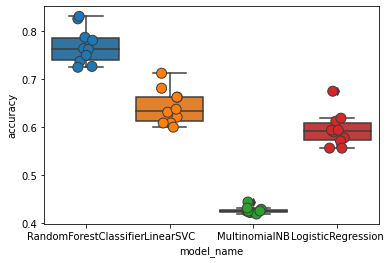

In [17]:
# Applying models

labels = df[1]
models = [
    RandomForestClassifier(n_estimators=200, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

cv_df = pd.DataFrame()
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=10)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=10, jitter=True, linewidth=1)
plt.show()

In [18]:
# Printing the accuracies
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.642601
LogisticRegression        0.594538
MultinomialNB             0.426704
RandomForestClassifier    0.769177
Name: accuracy, dtype: float64

## Appyling other models

In [19]:
X = features
y = df.iloc[:, 1].values

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Multinomial NB
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.46105919003115264


In [22]:
# Linear SVC
from sklearn.svm import SVC

classifier = SVC(kernel = 'linear', random_state = 0, C = 1, gamma = 0.1)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.5950155763239875


In [38]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.6542056074766355


In [37]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.6137071651090342


In [39]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_knn = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7227414330218068


In [41]:
# Kernal SVC RBF

classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_k_svc = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.660436137071651


In [27]:
# Kernal SVC sigmoid

classifier = SVC(kernel = 'sigmoid', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.5545171339563862


In [28]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_rf = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.8099688473520249


In [42]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_dt = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7663551401869159


## Creating a json file and sending to the server

In [43]:
cm_rf_p = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]
cm_lr_p = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]
cm_knn_p = cm_knn.astype('float') / cm_knn.sum(axis=1)[:, np.newaxis]
cm_k_svc_p = cm_k_svc.astype('float') / cm_k_svc.sum(axis=1)[:, np.newaxis]
cm_dt_p = cm_dt.astype('float') / cm_dt.sum(axis=1)[:, np.newaxis]

In [32]:
unique, counts = np.unique(y_pred, return_counts=True)

In [45]:
dict_pred_rf = dict(zip(unique, cm_rf_p.diagonal()))
dict_pred_lr = dict(zip(unique, cm_lr_p.diagonal()))
dict_pred_knn = dict(zip(unique, cm_knn_p.diagonal()))
dict_pred_k_svc = dict(zip(unique, cm_k_svc_p.diagonal()))
dict_pred_dt = dict(zip(unique, cm_dt_p.diagonal()))

In [70]:
import json

models = ['random_forest', 'linear_regression', 'knn', 'kernal_svc', 'decision_tree']
pred_dict = [dict_pred_rf, dict_pred_lr, dict_pred_knn, dict_pred_k_svc, dict_pred_dt]

predictions = {}
for model, pred in zip(models, pred_dict):
    predictions[model] = pred

with open('prediction.json', 'w') as json_file:
    json.dump(predictions, json_file)

In [65]:
predictions

{'random_forest': {'correction': 0.75,
  'imperative': 0.7446808510638298,
  'interrogative': 0.8933333333333333,
  'negative': 0.43478260869565216,
  'other': 0.64,
  'positive': 0.8775510204081632},
 'linear_regression': {'correction': 0.0,
  'imperative': 0.3617021276595745,
  'interrogative': 0.6266666666666667,
  'negative': 0.0,
  'other': 0.0,
  'positive': 0.9931972789115646},
 'knn': {'correction': 0.5,
  'imperative': 0.6170212765957447,
  'interrogative': 0.72,
  'negative': 0.2608695652173913,
  'other': 0.24,
  'positive': 0.9183673469387755},
 'kernal_svc': {'correction': 0.0,
  'imperative': 0.5319148936170213,
  'interrogative': 0.6,
  'negative': 0.0,
  'other': 0.0,
  'positive': 0.9659863945578231},
 'decision_tree': {'correction': 1.0,
  'imperative': 0.723404255319149,
  'interrogative': 0.84,
  'negative': 0.43478260869565216,
  'other': 0.68,
  'positive': 0.8027210884353742}}